In [1]:
from scipy.stats import skew, kurtosis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier,ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')


In [2]:
df=pd.read_csv('cardio_train.csv', delimiter=';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
df['age']=df['age'].apply(lambda x: x/365).astype(int)

In [4]:
df['height']=df['height'].apply(lambda x: x/100)

In [5]:
df.drop("id", axis = 1 , inplace = True )

In [6]:
import pandas as pd
from imblearn.over_sampling import SMOTE

columns_to_up_sample = ['cholesterol', 'gluc', 'smoke', 'alco', 'active']  # These are the columns with imbalanced categories

# Create a copy of the original dataframe to preserve it
df_copy = df.copy()

# Loop through each column in the columns_to_up_sample list
for column in columns_to_up_sample:
    print(f"################## UP SAMPLING : {column} ##################")
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    # Extract the column to treat as the target variable (y)
    X = df_copy.drop(columns=column)  # All other columns except the current one
    y = df_copy[column]  # The column we want to upsample
    
    X_res, y_res = smote.fit_resample(X, y)
    X_res[column] = y_res 

    df_copy =  X_res.copy() 



################## UP SAMPLING : cholesterol ##################
################## UP SAMPLING : gluc ##################
################## UP SAMPLING : smoke ##################
################## UP SAMPLING : alco ##################
################## UP SAMPLING : active ##################


In [7]:
print("New Dataset Shape : " , df_copy.shape )

df = df_copy


New Dataset Shape :  (1877000, 12)


In [8]:
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']

df['map'] = df['ap_lo'] + (df['ap_hi'] - df['ap_lo'])/3

df['bmi']=df['weight']/(df['height'])**2

df['sys_dsys_ratio'] = df['ap_hi'] / df['ap_lo']


In [9]:
df['cholesterol']=df['cholesterol'].apply(lambda x: 'normal' if x==1 else('above_normal' if x==2 else 'well_above_normal'))
df['gluc']=df['gluc'].apply(lambda x: 'normal' if x==1 else('above_normal' if x==2 else 'well_above_normal'))

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1877000 entries, 0 to 1876999
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   age             int32  
 1   gender          int64  
 2   height          float64
 3   weight          float64
 4   ap_hi           int64  
 5   ap_lo           int64  
 6   cardio          int64  
 7   cholesterol     object 
 8   gluc            object 
 9   smoke           int64  
 10  alco            int64  
 11  active          int64  
 12  pulse_pressure  int64  
 13  map             float64
 14  bmi             float64
 15  sys_dsys_ratio  float64
dtypes: float64(5), int32(1), int64(8), object(2)
memory usage: 222.0+ MB


In [11]:
num_cols=df.select_dtypes(exclude='object').columns
cat_cols=df.select_dtypes(include='object').columns

In [12]:
from scipy.stats import boxcox
age=np.array(df['age'])
_, opt_lambda=boxcox(age)
print(opt_lambda)

1.294694801906814


In [46]:
joblib.dump(opt_lambda, "opt_lambda.pkl")

['opt_lambda.pkl']

In [13]:
df['age_box']=boxcox(df['age'], lmbda=opt_lambda)

In [14]:
features=df[['age_box','weight', 'cholesterol', 'gluc', 'smoke', 'alco','pulse_pressure', 'map', 'bmi']]
target=df['cardio']

In [15]:
num_features=features.select_dtypes(exclude='object').columns
cat_features=features.select_dtypes(include='object').columns

In [16]:
num_features

Index(['age_box', 'weight', 'smoke', 'alco', 'pulse_pressure', 'map', 'bmi'], dtype='object')

In [17]:
cat_features

Index(['cholesterol', 'gluc'], dtype='object')

In [18]:
features

,age_box,weight,cholesterol,gluc,smoke,alco,pulse_pressure,map,bmi
0,121.542761,62.000000,normal,normal,0,0,30,90.000000,21.967120
1,137.606915,85.000000,well_above_normal,normal,0,0,50,106.666667,34.927679
2,124.719266,64.000000,well_above_normal,normal,0,0,60,90.000000,23.507805
3,115.246021,82.000000,normal,normal,0,0,50,116.666667,28.710479
4,112.126333,56.000000,normal,normal,0,0,40,73.333333,23.011177
...,...,...,...,...,...,...,...,...,...
1876995,137.606915,83.000000,normal,normal,1,0,80,126.666667,29.873461
1876996,102.885476,80.643589,normal,normal,1,1,60,120.000000,28.939903
1876997,105.945756,89.041167,normal,normal,1,1,50,106.666667,34.350297
1876998,127.914181,75.084282,normal,normal,1,0,60,90.000000,23.361417


In [19]:
target

0          0
1          1
2          1
3          1
4          0
          ..
1876995    1
1876996    1
1876997    1
1876998    0
1876999    1
Name: cardio, Length: 1877000, dtype: int64

In [20]:
scaler=StandardScaler()

In [ ]:
features[num_features]=scaler.fit_transform(features[num_features])

In [48]:
scaler.fit(features[num_features])

StandardScaler()

In [22]:
features

,age_box,weight,cholesterol,gluc,smoke,alco,pulse_pressure,map,bmi
0,-0.292786,-1.135967,normal,normal,-1.510045,-1.005868,-0.021770,-0.181168,-1.187084
1,0.477941,0.281639,well_above_normal,normal,-1.510045,-1.005868,0.093738,-0.026162,1.270717
2,-0.140383,-1.012697,well_above_normal,normal,-1.510045,-1.005868,0.151493,-0.181168,-0.894913
3,-0.594892,0.096734,normal,normal,-1.510045,-1.005868,0.093738,0.066841,0.091706
4,-0.744568,-1.505778,normal,normal,-1.510045,-1.005868,0.035984,-0.336173,-0.989092
...,...,...,...,...,...,...,...,...,...
1876995,0.477941,0.158369,normal,normal,0.662232,-1.005868,0.267001,0.159844,0.312250
1876996,-1.187927,0.013132,normal,normal,0.662232,0.994166,0.151493,0.097842,0.135213
1876997,-1.041101,0.530717,normal,normal,0.662232,0.994166,0.093738,-0.026162,1.161224
1876998,0.012902,-0.329517,normal,normal,0.662232,-1.005868,0.151493,-0.181168,-0.922674


In [23]:
features=pd.get_dummies(features, columns=['cholesterol', 'gluc'])

In [24]:
features

,age_box,weight,smoke,alco,pulse_pressure,map,bmi,cholesterol_above_normal,cholesterol_normal,cholesterol_well_above_normal,gluc_above_normal,gluc_normal,gluc_well_above_normal
0,-0.292786,-1.135967,-1.510045,-1.005868,-0.021770,-0.181168,-1.187084,False,True,False,False,True,False
1,0.477941,0.281639,-1.510045,-1.005868,0.093738,-0.026162,1.270717,False,False,True,False,True,False
2,-0.140383,-1.012697,-1.510045,-1.005868,0.151493,-0.181168,-0.894913,False,False,True,False,True,False
3,-0.594892,0.096734,-1.510045,-1.005868,0.093738,0.066841,0.091706,False,True,False,False,True,False
4,-0.744568,-1.505778,-1.510045,-1.005868,0.035984,-0.336173,-0.989092,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1876995,0.477941,0.158369,0.662232,-1.005868,0.267001,0.159844,0.312250,False,True,False,False,True,False
1876996,-1.187927,0.013132,0.662232,0.994166,0.151493,0.097842,0.135213,False,True,False,False,True,False
1876997,-1.041101,0.530717,0.662232,0.994166,0.093738,-0.026162,1.161224,False,True,False,False,True,False
1876998,0.012902,-0.329517,0.662232,-1.005868,0.151493,-0.181168,-0.922674,False,True,False,False,True,False


In [25]:
x_train, x_test, y_train, y_test = train_test_split(features, target, random_state=42,test_size=.33)

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

In [27]:
# Estimators list
estimators = [
    ('rf', RandomForestClassifier(n_estimators=30, max_depth=10 ,random_state=42)),
    ('et', ExtraTreesClassifier(
                n_estimators=30, 
                max_depth=10,
                min_samples_split=5,
                min_samples_leaf=2,
                max_features='sqrt',  # Correct assignment
                random_state=42
            )),
   ('gb', GradientBoostingClassifier(n_estimators=30, learning_rate=1.0,
    max_depth=1, random_state=0)),
    ('ab', AdaBoostClassifier(n_estimators=30, random_state=0)),
    ('XG', XGBClassifier(objective='binary:logistic', learning_rate=0.1, max_depth=10, n_estimators=10, seed=42)),
    ('LG', LGBMClassifier(n_estimators=30, learning_rate=0.1, random_state=42))
]

# Store results for each model
results = []

# Loop through models and evaluate
for model in estimators:
    model_name = model[0]
    model_instance = model[1]
    
    # Train the model
    model_instance.fit(x_train, y_train)
    y_pred = model_instance.predict(x_test)
    
    # Store results
    results.append({
        'model': model_name,
        'y_true': y_test,
        'y_pred': y_pred,
        'model_instance': model_instance
    })

# clf = StackingClassifier(
#     estimators=estimators, final_estimator= LogisticRegression()
# )

# clf.fit( x_train , y_train )

# y_pred = clf.predict( x_test )
# accuracy_score(y_test, y_pred)


[LightGBM] [Info] Number of positive: 480311, number of negative: 777279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 940
[LightGBM] [Info] Number of data points in the train set: 1257590, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.381930 -> initscore=-0.481366
[LightGBM] [Info] Start training from score -0.481366


Model Name :rf | Accuracy: 0.9238785295684603


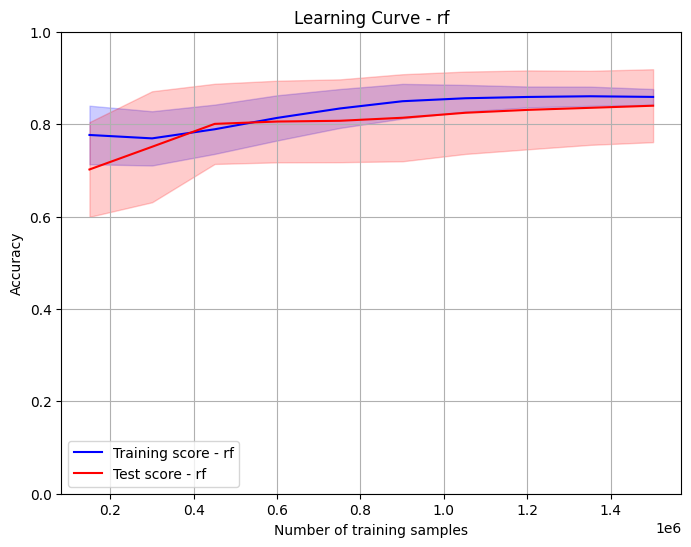

Model Name :et | Accuracy: 0.7675439531166756


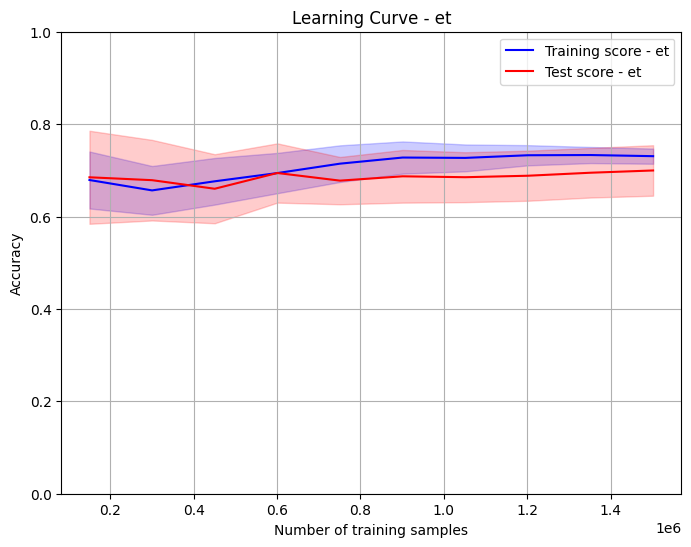

Model Name :gb | Accuracy: 0.8173201917954183


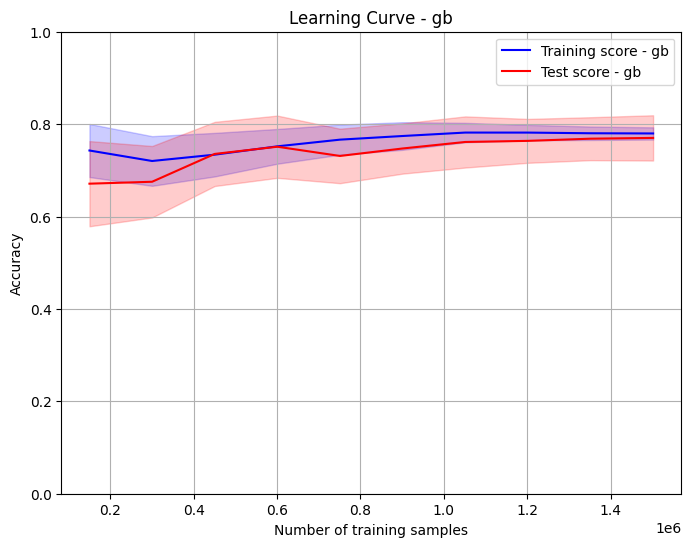

Model Name :ab | Accuracy: 0.8376984549813532


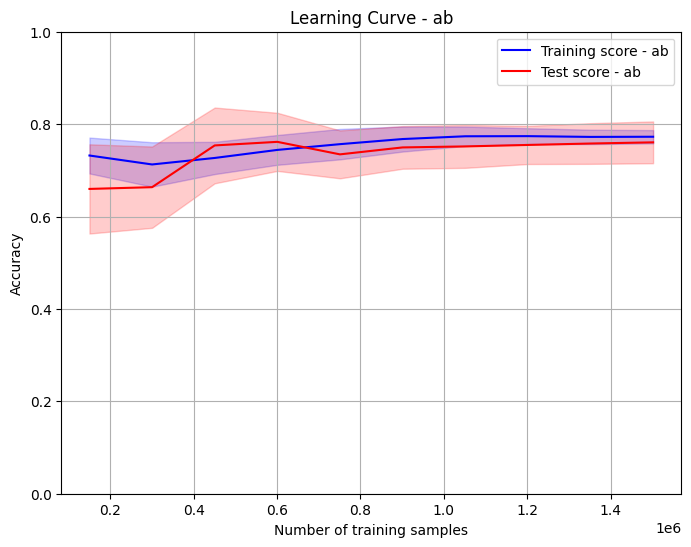

Model Name :XG | Accuracy: 0.9393953116675546


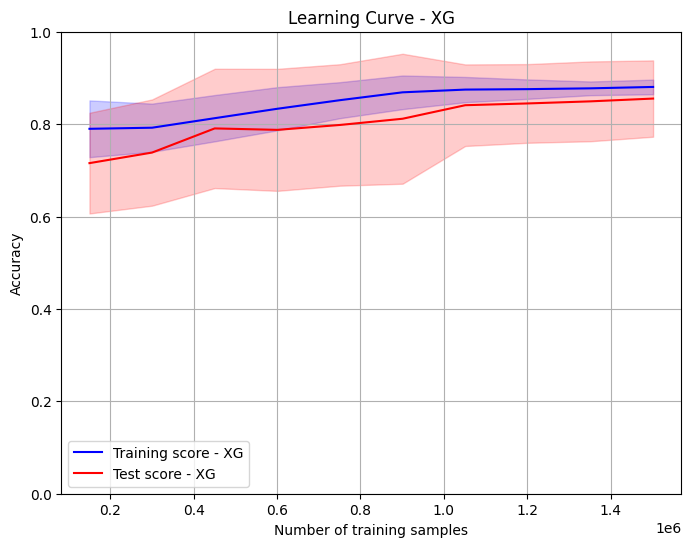

Model Name :LG | Accuracy: 0.9054661694192861


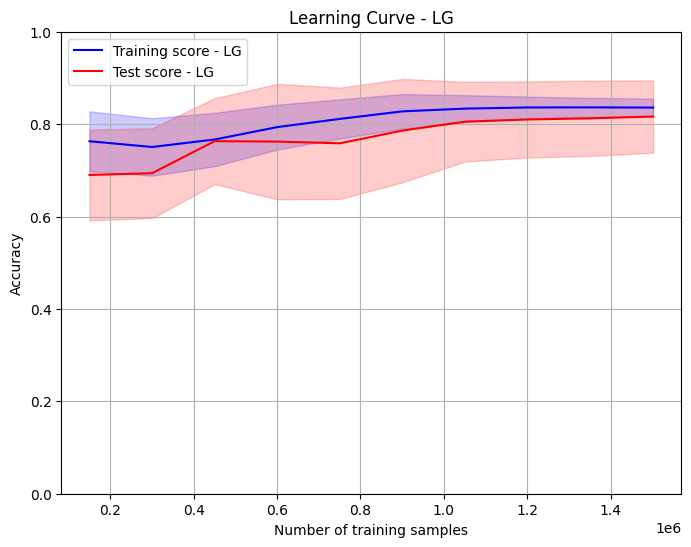

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Learning curve plot
for result in results:
    model_name = result['model']
    model_instance = result['model_instance']

    
    
    # Calculate learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        model_instance, features, target, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
    )

    print(f"Model Name :{model_name} | Accuracy: {test_scores.max()}")
    
    # Calculate mean and std of train and test scores
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_mean = test_scores.mean(axis=1)
    test_std = test_scores.std(axis=1)
    
    # Plot the learning curve
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label=f'Training score - {model_name}', color='blue')
    plt.plot(train_sizes, test_mean, label=f'Test score - {model_name}', color='red')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.2)
    
    plt.title(f'Learning Curve - {model_name}')
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Adjust y-axis to range from 0 to 1
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


In [29]:
for result in results:
    model_name = result['model']
    y_true = result['y_true']
    y_pred = result['y_pred']
    model_instance = result['model_instance']

    print(f"####### {model_name} ######## Accuracy: ")
    print(classification_report(y_true, y_pred))
    

####### rf ######## Accuracy: 
              precision    recall  f1-score   support

           0       0.89      0.88      0.88    382775
           1       0.81      0.82      0.81    236635

    accuracy                           0.86    619410
   macro avg       0.85      0.85      0.85    619410
weighted avg       0.86      0.86      0.86    619410

####### et ######## Accuracy: 
              precision    recall  f1-score   support

           0       0.72      0.91      0.81    382775
           1       0.75      0.44      0.56    236635

    accuracy                           0.73    619410
   macro avg       0.74      0.67      0.68    619410
weighted avg       0.73      0.73      0.71    619410

####### gb ######## Accuracy: 
              precision    recall  f1-score   support

           0       0.80      0.85      0.82    382775
           1       0.73      0.66      0.70    236635

    accuracy                           0.78    619410
   macro avg       0.77      0.76  

Confusion Matrix - rf:


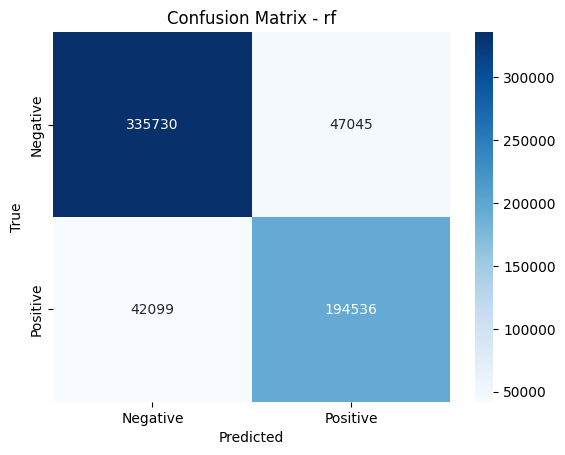

Confusion Matrix - et:


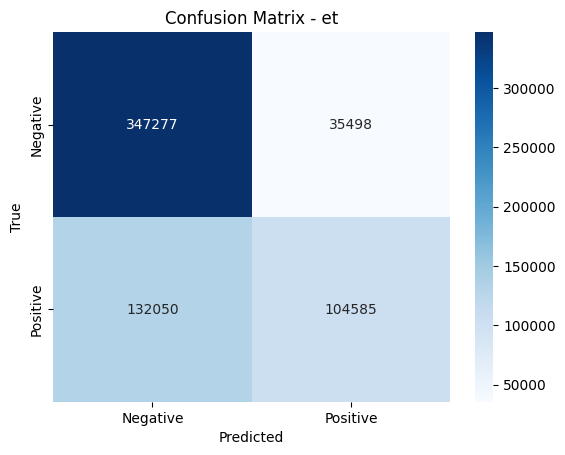

Confusion Matrix - gb:


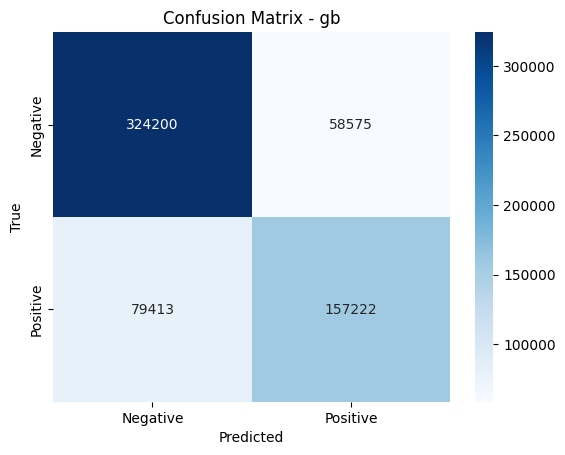

Confusion Matrix - ab:


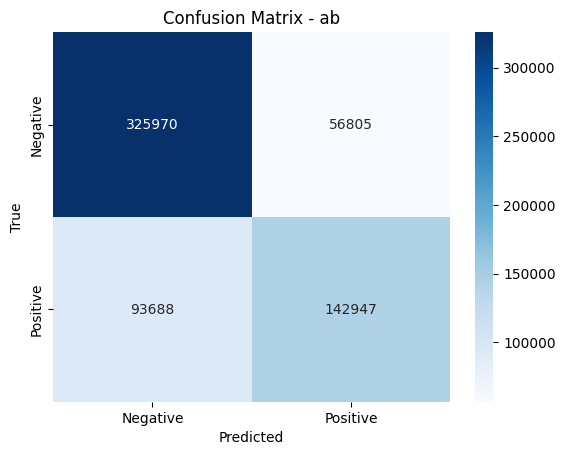

Confusion Matrix - XG:


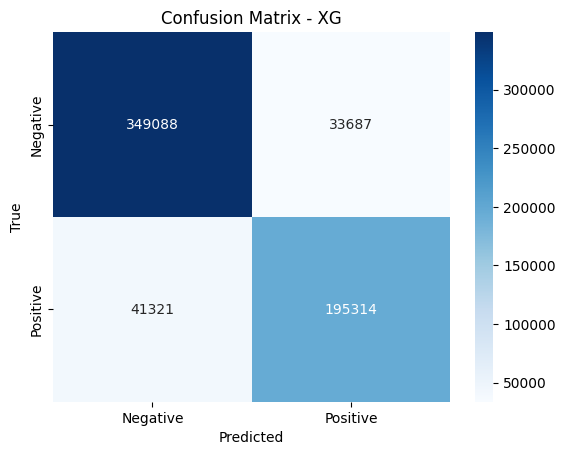

Confusion Matrix - LG:


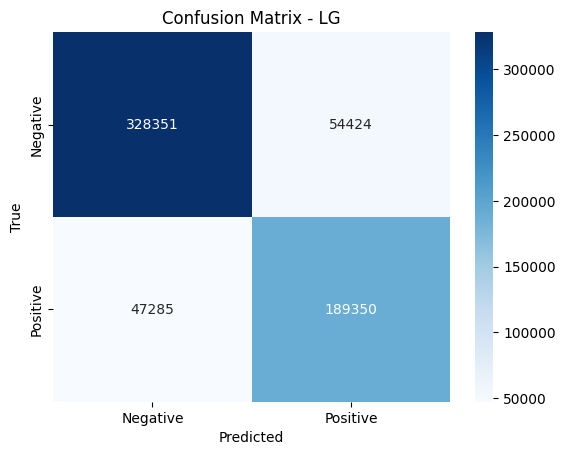

In [30]:
for result in results:
    model_name = result['model']
    y_true = result['y_true']
    y_pred = result['y_pred']
    
    # Confusion Matrix
    print(f"Confusion Matrix - {model_name}:")
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot Confusion Matrix using Seaborn heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

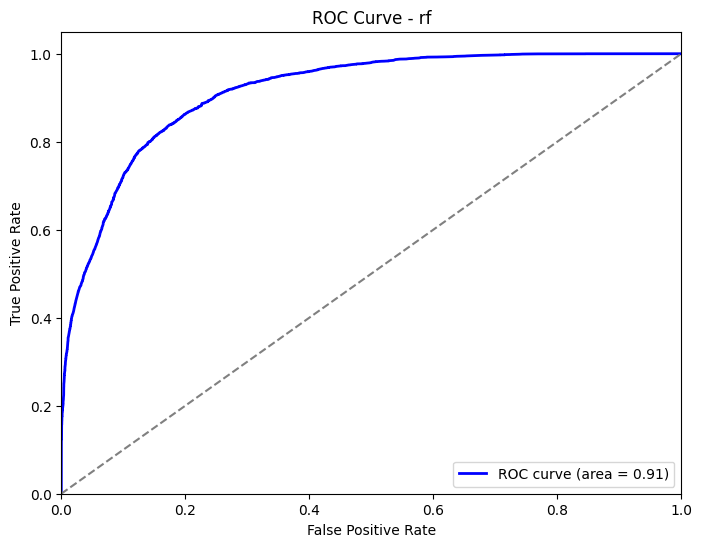

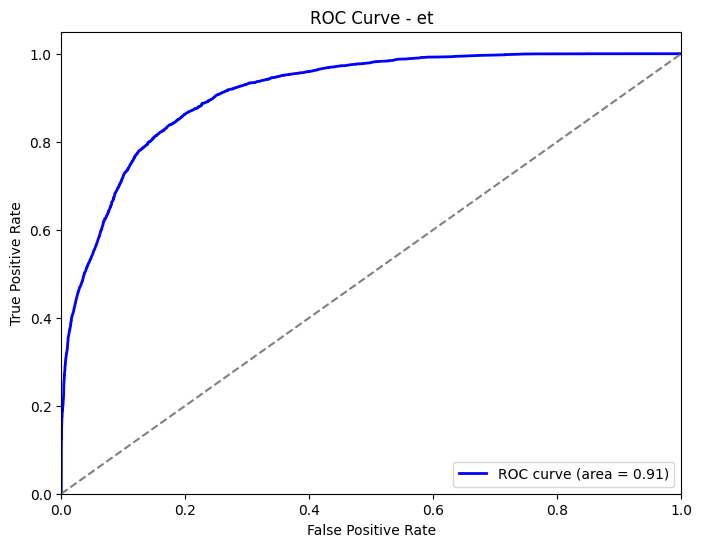

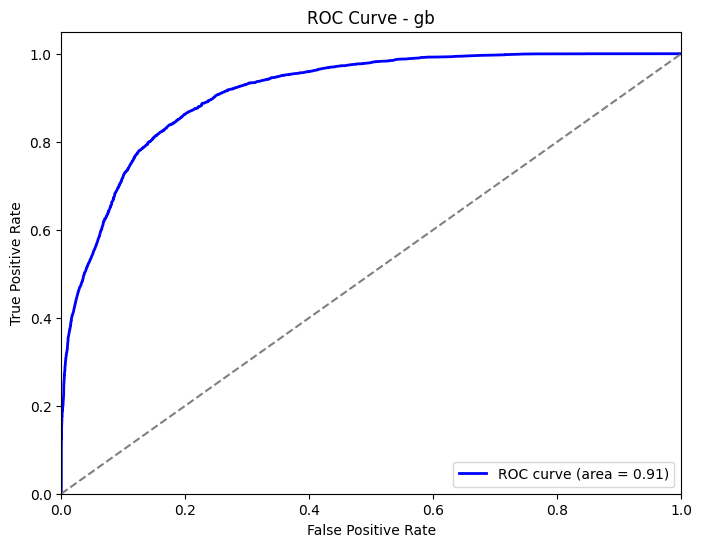

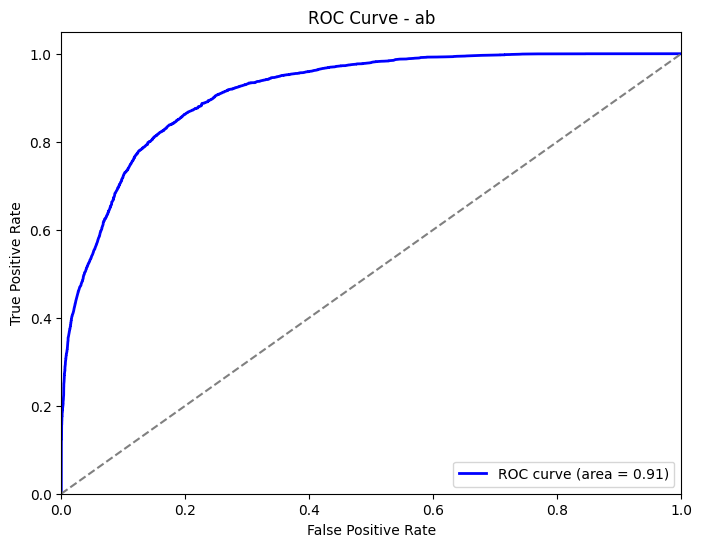

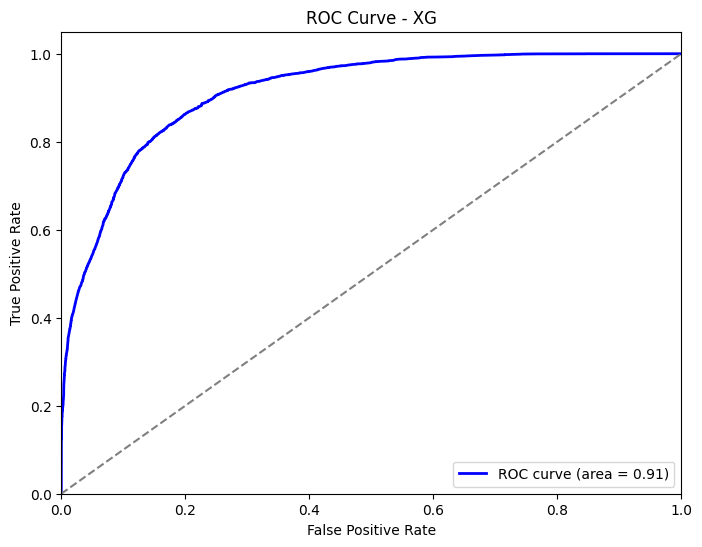

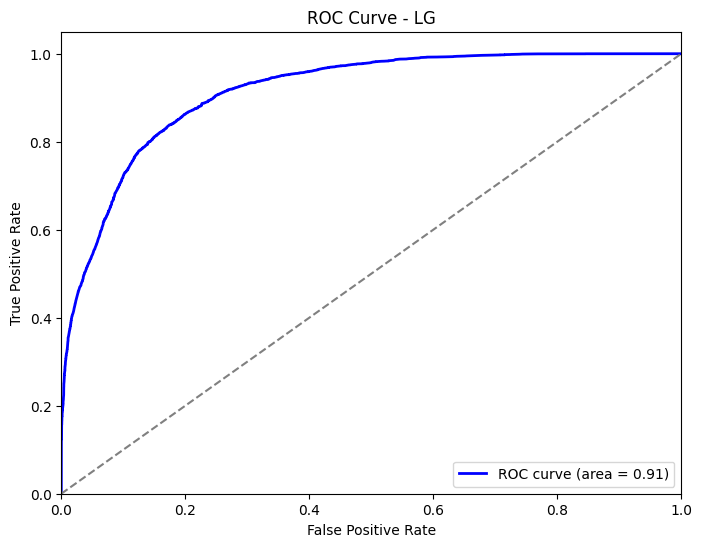

In [31]:
 # ROC Curve
for result in results:
    model_name = result['model']
    y_true = result['y_true']
    y_pred = result['y_pred']
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, model_instance.predict_proba(x_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

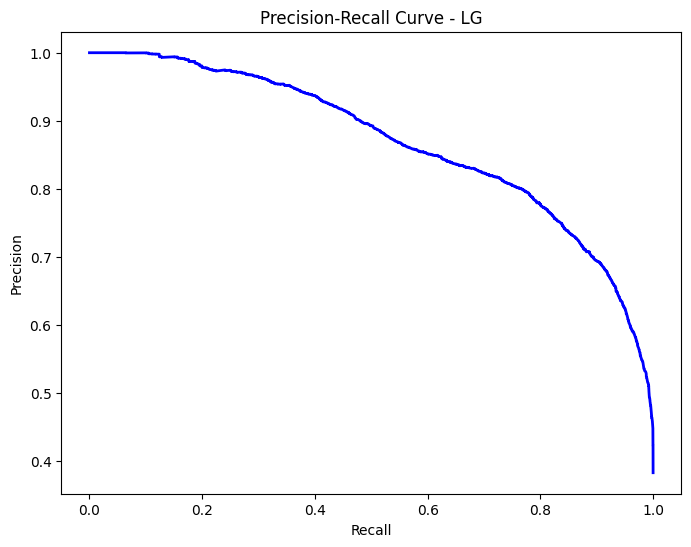

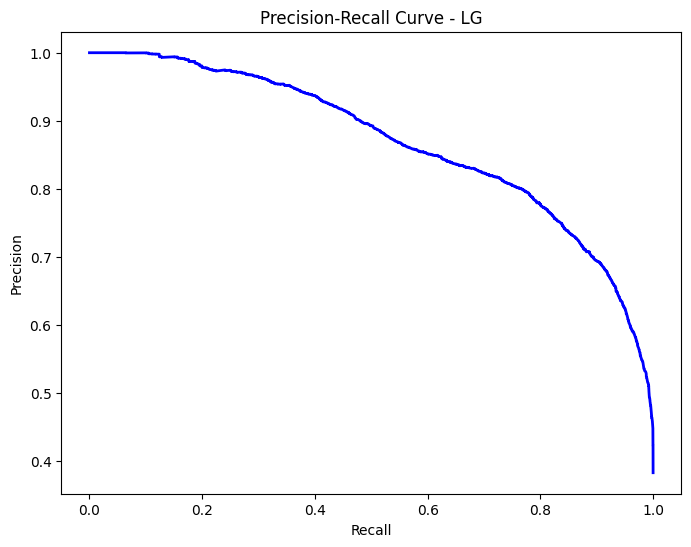

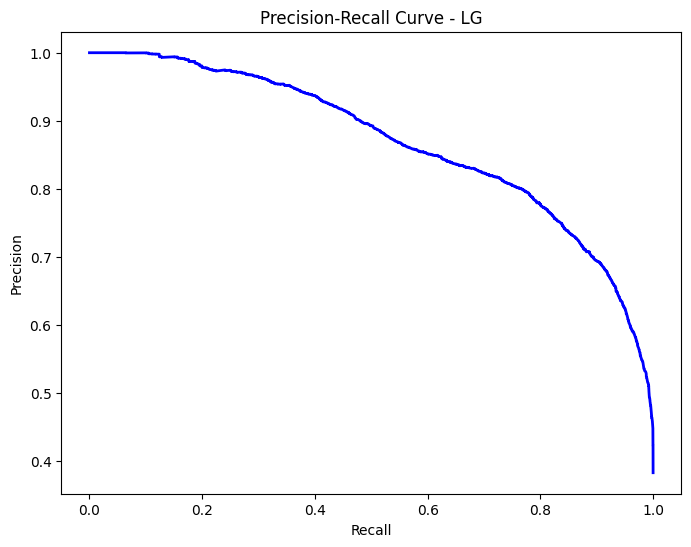

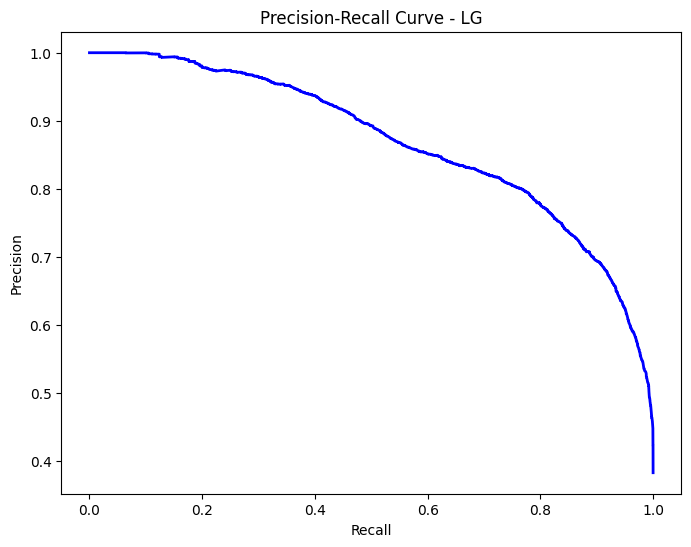

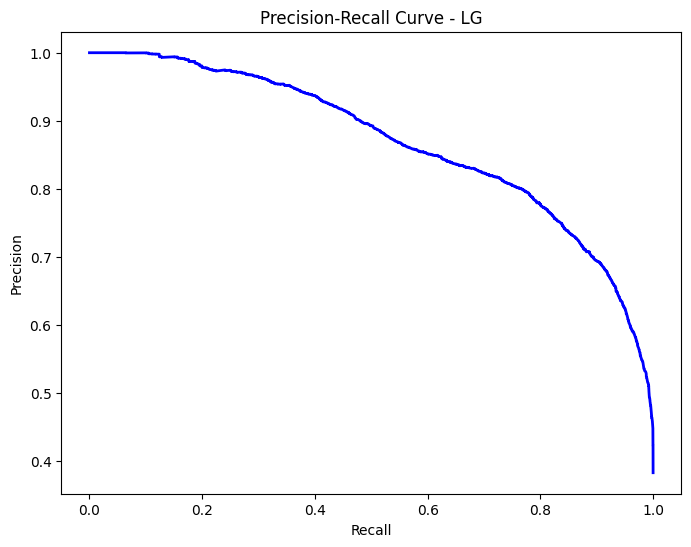

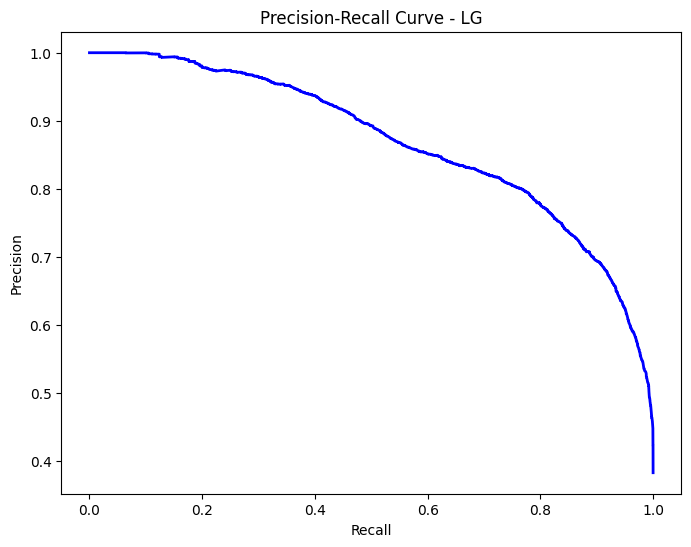

In [32]:
# Precision-Recall Curve
for result in results:
    precision, recall, _ = precision_recall_curve(y_test, model[1].predict_proba(x_test)[:,1])
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model[0]}')
    plt.show()

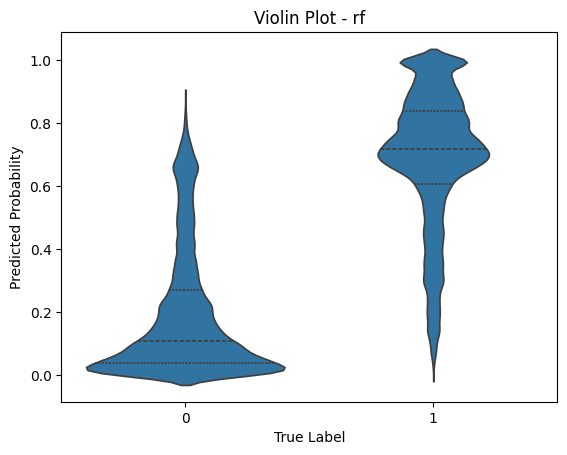

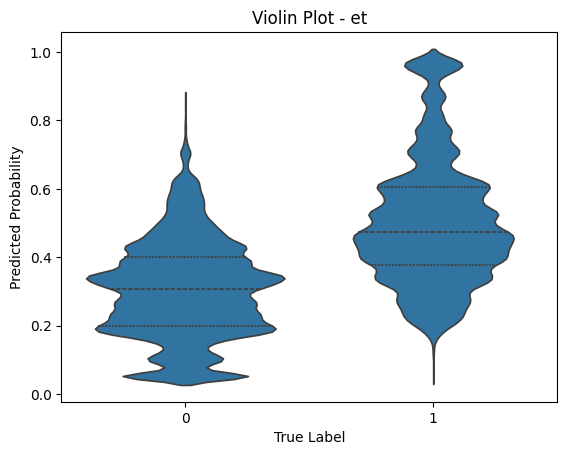

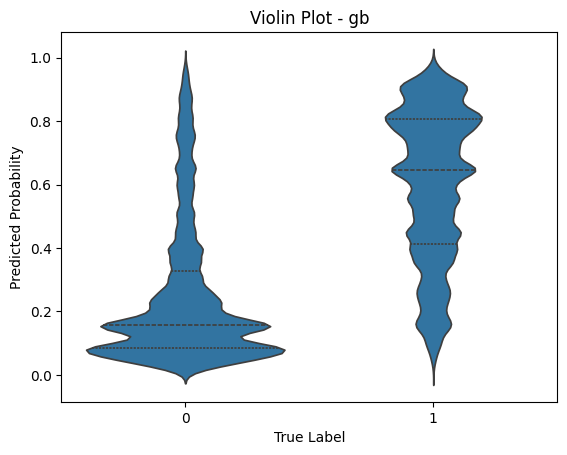

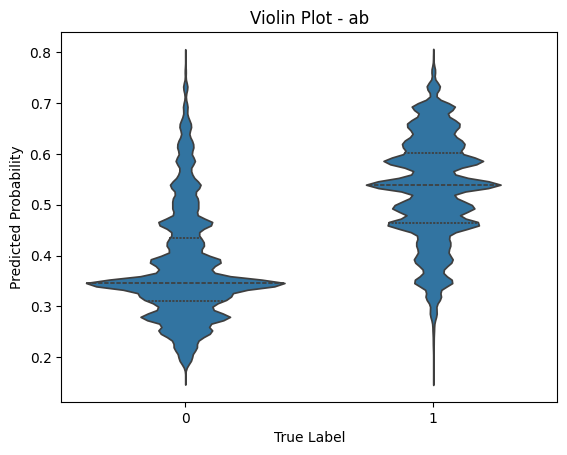

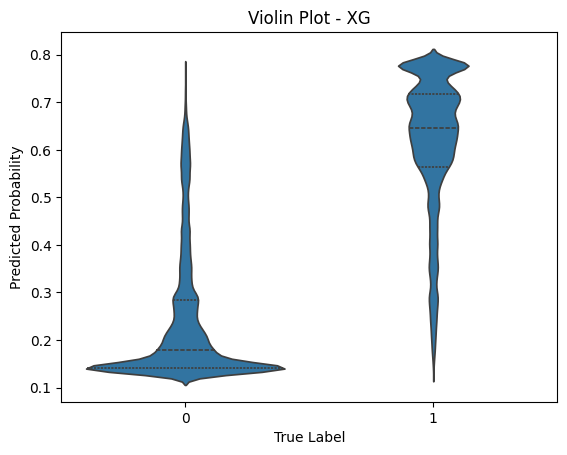

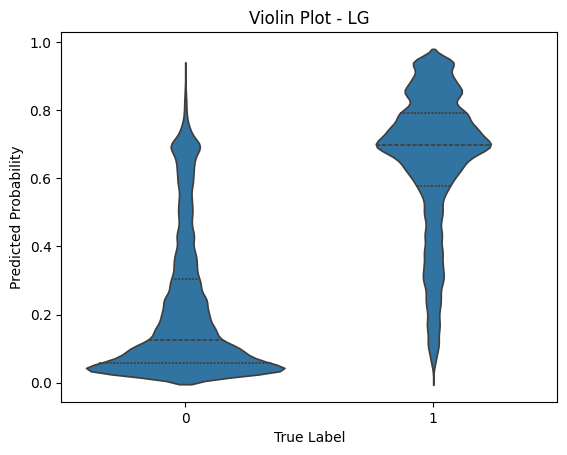

In [33]:
for result in results:
    model_name = result['model']
    model_instance = result['model_instance']
    y_true = result['y_true']
    y_pred = result['y_pred']
    
    # Violin Plot for model predictions vs. true labels
    sns.violinplot(x=y_true, y=model_instance.predict_proba(x_test)[:,1], inner='quart')
    plt.title(f'Violin Plot - {model_name}')
    plt.xlabel('True Label')
    plt.ylabel('Predicted Probability')
    plt.show()

In [34]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

In [35]:
# Initialize the base models (RandomForest, ExtraTrees, XGBoost)
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=30, random_state=42)),
    ('et', ExtraTreesClassifier(n_estimators=30, random_state=42)),
    ('xgb', XGBClassifier(objective='binary:logistic', learning_rate=0.1, max_depth=10, n_estimators=30, seed=42))
]

In [36]:
# Final estimator (Logistic Regression in this case)
final_estimator = LogisticRegression()

In [37]:
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=final_estimator)

In [38]:
# Get learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    stacking_model, x_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

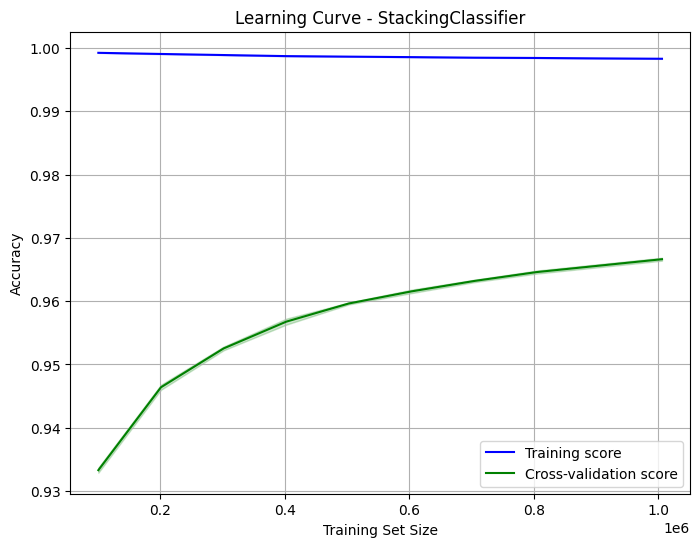

In [39]:
# Calculate mean and std deviation for plotting
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.plot(train_sizes, test_mean, label='Cross-validation score', color='green')

# Plot the std deviation area
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.2)

plt.title(f"Learning Curve - StackingClassifier")
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [40]:
x_train

,age_box,weight,smoke,alco,pulse_pressure,map,bmi,cholesterol_above_normal,cholesterol_normal,cholesterol_well_above_normal,gluc_above_normal,gluc_normal,gluc_well_above_normal
1870214,-1.041101,0.694483,0.662232,0.994166,0.035984,0.035840,0.403662,True,False,False,True,False,False
1280049,-1.187927,2.096038,0.662232,0.994166,0.093738,-0.026162,1.636075,True,False,False,True,False,False
859076,-1.041101,0.636346,0.662232,0.994166,0.035984,0.035840,0.183055,True,False,False,True,False,False
1207694,0.634644,-0.971027,0.662232,0.994166,0.093738,-0.026162,-0.558472,False,True,False,False,True,False
169182,-0.744568,-0.860870,-1.510045,-1.005868,0.035984,-0.150167,-0.463739,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,1.754159,-0.749231,-1.510045,-1.005868,0.041760,-0.063364,-0.522688,True,False,False,True,False,False
1414414,-1.041101,-0.889427,0.662232,-1.005868,0.082188,0.079241,-0.457078,False,False,True,False,True,False
131932,1.269621,0.836150,-1.510045,-1.005868,0.318979,0.187745,1.872343,False,False,True,False,False,True
671155,0.950519,2.347440,0.662232,-1.005868,0.076412,-0.128466,3.058091,True,False,False,False,True,False


In [41]:
# Train the stacking model
stacking_model.fit(x_train, y_train)

# Make predictions and evaluate the model
y_pred = stacking_model.predict(x_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97    382775
           1       0.96      0.96      0.96    236635

    accuracy                           0.97    619410
   macro avg       0.97      0.97      0.97    619410
weighted avg       0.97      0.97      0.97    619410



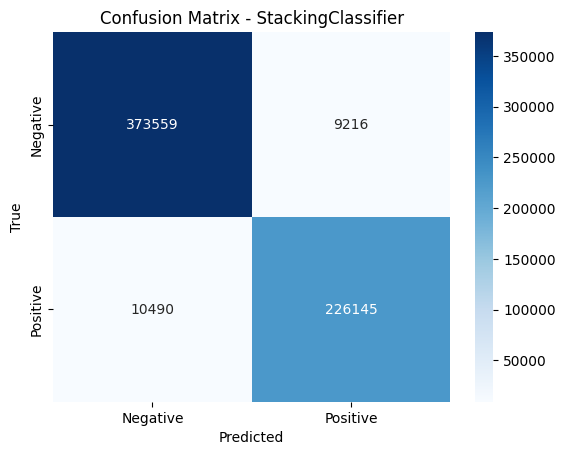

In [42]:
# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title(f"Confusion Matrix - StackingClassifier")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [43]:
import joblib
joblib.dump(stacking_model, "heart.pkl")
# model = joblib.load("model.pkl")


['heart.pkl']

In [49]:
joblib.dump(scaler, 'scaler.pkl')
print("Successfully saved scaler.pkl")

Successfully saved scaler.pkl
